<a href="https://colab.research.google.com/github/Ridwan1821/TeamGM2/blob/nnaemeka/movie_recommender_system_nnaemeka.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Connect Kaggle to Google Collab

In [132]:
! pip install -q kaggle

In [133]:
from google.colab import files

In [134]:
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"laskyupgraded","key":"d7168356e9b319752189b16f600a3df1"}'}

In [135]:
#! mkdir ~/.kaggle
#! cp kaggle.json ~/.kaggle/

In [136]:
! chmod 600 ~/.kaggle/kaggle.json

In [137]:
! kaggle datasets list

ref                                                             title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
ahsan81/hotel-reservations-classification-dataset               Hotel Reservations Dataset                         480KB  2023-01-04 12:50:31           8847        304  1.0              
googleai/musiccaps                                              MusicCaps                                          793KB  2023-01-25 09:25:48           1716        178  0.9411765        
themrityunjaypathak/most-subscribed-1000-youtube-channels       Most Subscribed 1000 Youtube Channels               28KB  2023-01-21 14:42:05           2184         72  1.0              
nitishsharma01/olympics-124-years-datasettill-2020              O

In [138]:
#download data from kaggle into collab
#! kaggle competitions download -c 'EDSA-Movie-Recommendation-Predict'

In [139]:
# make directory named movies and unzip the downloaded file into it
#! mkdir movies
#! unzip EDSA-Movie-Recommendation-Predict.zip -d movies

**1.** **Introduction**

![](https://miro.medium.com/max/1400/0*NqJrlluUhlcZvGTx)

The [recommender system](https://en.wikipedia.org/wiki/Recommender_system) is a data science algorithm we employ to suggest items to users of a platform based on their product preferences or personal lifestyle. Recommender systems are particularly useful when an individual needs to choose an item from a potentially overwhelming number of items that a service may offer.

From Facebook, Amazon, DataQuest down to every e-commerce website, recommender systems are used to suggest a new friend, what product a customer might like or another course a student should sign up for.

**1.2** **Problem Statement**

In this challenge, we want to build a Collaborative Filtering model that will effectively recommend best movies to a customer based on their personal preferences.

**1.3 The Dataset**

For this challenge, we have been provided with a pack of dateset with millions of movie data. 

# **2.** **Libraries and Dataset**



**2.1 Import required libraries**

We import inbuilt python libraries to help us with the task.

In [140]:
#import data manipulation libraries
import pandas as pd
import numpy as np
import scipy as sp

#import data visualization tools
import matplotlib.pyplot as plt
import seaborn as sns

#import machine learning tools
from sklearn.preprocessing import StandardScaler

from nltk.stem import WordNetLemmatizer, SnowballStemmer
snowball = SnowballStemmer(language = 'english')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud, wordcloud_cli

import datetime


# **2.2 Load Datasets**

**2.2.1 genome scores data**

In [141]:
# Load genome scores data
gs = pd.read_csv('movies/genome_scores.csv')

#check number of rows and columns availbale
print('Rows -', gs.shape[0], '\nColumns -', gs.shape[1], '\n')

gs.head()

Rows - 15584448 
Columns - 3 



,movieId,tagId,relevance
0,1,1,0.02875
1,1,2,0.02375
2,1,3,0.06250
3,1,4,0.07575
4,1,5,0.14075


**2.2.2 genome tags data**

In [142]:
gt = pd.read_csv('movies/genome_tags.csv')

#check number of rows and columns availbale
print('Rows -', gt.shape[0], '\nColumns -', gt.shape[1], '\n')

gt.head()

Rows - 1128 
Columns - 2 



,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


**2.2.3 IMDB data**

In [143]:
imd = pd.read_csv('movies/imdb_data.csv')
imdc = pd.read_csv('movies/imdb_data.csv')
#check number of rows and columns availbale
print('Rows -', imd.shape[0], '\nColumns -', imd.shape[1], '\n')

imd.head()

Rows - 27278 
Columns - 6 



,movieId,title_cast,director,runtime,budget,plot_keywords
0,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation
1,2,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,104.0,"$65,000,000",board game|adventurer|fight|game
2,3,Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...,Mark Steven Johnson,101.0,"$25,000,000",boat|lake|neighbor|rivalry
3,4,Whitney Houston|Angela Bassett|Loretta Devine|...,Terry McMillan,124.0,"$16,000,000",black american|husband wife relationship|betra...
4,5,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,106.0,"$30,000,000",fatherhood|doberman|dog|mansion


In [144]:
# check count of observations and presence of missing values
imd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27278 entries, 0 to 27277
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   movieId        27278 non-null  int64  
 1   title_cast     17210 non-null  object 
 2   director       17404 non-null  object 
 3   runtime        15189 non-null  float64
 4   budget         7906 non-null   object 
 5   plot_keywords  16200 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 1.2+ MB


The `imd.info()` check above reveals the `imd` data has missing values in the `title_cast`, `director`, `runtime`, `budeget` and `plot_keywords` columns.

**2.2.4 links dataset**

In [145]:
# load links dataset
ld = pd.read_csv('movies/links.csv')
ld.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


**2.2.5 movies meta dataset**

In [146]:
# load movies dataset
mv = pd.read_csv('movies/movies.csv')
mv.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [147]:
mv.shape

(62423, 3)

**2.2.6 sample submission file**

Let's a sample file for making the challenge submission.

In [148]:
ss = pd.read_csv('movies/sample_submission.csv')
ss.head()

,Id,rating
0,1_2011,1.0
1,1_4144,1.0
2,1_5767,1.0
3,1_6711,1.0
4,1_7318,1.0


**2.2.7 tags data**

In [149]:
#load the tags dataset
tg = pd.read_csv('movies/tags.csv')
tg.head()

,userId,movieId,tag,timestamp
0,3,260,classic,1439472355
1,3,260,sci-fi,1439472256
2,4,1732,dark comedy,1573943598
3,4,1732,great dialogue,1573943604
4,4,7569,so bad it's good,1573943455


In [150]:
# check for missing values in the data
tg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1093360 entries, 0 to 1093359
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   userId     1093360 non-null  int64 
 1   movieId    1093360 non-null  int64 
 2   tag        1093344 non-null  object
 3   timestamp  1093360 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 33.4+ MB


Only the `tag` column has missing data - very insignificant count at first glance.

In [151]:
# missing values < 0.01%
((len(tg) - tg.tag.count())/len(tg)) * 100

0.0014633789419770248

**2.2.8 test data**

In [152]:
#load test data
ts = pd.read_csv('movies/test.csv')
ts.head()

,userId,movieId
0,1,2011
1,1,4144
2,1,5767
3,1,6711
4,1,7318


In [153]:
# create a column of userId and movieId
#ts['user_movie'] = ts.apply(lambda x: '%s_%s' %(x['userId'], x['movieId']), axis = 1)





**2.2.9 train data**

In [154]:
tr = pd.read_csv('movies/train.csv')
tr.head()

,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,106343,5,4.5,1206238739
2,146790,5459,5.0,1076215539
3,106362,32296,2.0,1423042565
4,9041,366,3.0,833375837


# **3. Exploratory Data Analysis**

**3.1.1 genome scores data**

In [155]:
# check data details
gs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15584448 entries, 0 to 15584447
Data columns (total 3 columns):
 #   Column     Dtype  
---  ------     -----  
 0   movieId    int64  
 1   tagId      int64  
 2   relevance  float64
dtypes: float64(1), int64(2)
memory usage: 356.7 MB


In [156]:

# percentage missing values
gs.isnull().mean()

movieId      0.0
tagId        0.0
relevance    0.0
dtype: float64

In [157]:
# summary statistics of data
gs.describe().T

,count,mean,std,min,25%,50%,75%,max
movieId,15584448.0,46022.487261,55352.211318,1.00000,3853.750,8575.5000,80186.50000,206499.0
tagId,15584448.0,564.500000,325.625434,1.00000,282.750,564.5000,846.25000,1128.0
relevance,15584448.0,0.116368,0.154472,0.00025,0.024,0.0565,0.14075,1.0





**3.1.2 genome tags**


In [158]:
gt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1128 entries, 0 to 1127
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tagId   1128 non-null   int64 
 1   tag     1128 non-null   object
dtypes: int64(1), object(1)
memory usage: 17.8+ KB


genome tags data has no missing values.

In [159]:
# summary statistics
gt.describe().T

,count,mean,std,min,25%,50%,75%,max
tagId,1128.0,564.5,325.769857,1.0,282.75,564.5,846.25,1128.0


**3.1.3 imbd data**

In [160]:
# check data details
imd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27278 entries, 0 to 27277
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   movieId        27278 non-null  int64  
 1   title_cast     17210 non-null  object 
 2   director       17404 non-null  object 
 3   runtime        15189 non-null  float64
 4   budget         7906 non-null   object 
 5   plot_keywords  16200 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 1.2+ MB


In [161]:
# evaluate percentage missing values
imd.isnull().mean()*100

movieId           0.000000
title_cast       36.908864
director         36.197668
runtime          44.317765
budget           71.016937
plot_keywords    40.611482
dtype: float64

We found lots of columns with missing values in the IMBD data; we will drop columns with missing entries in `title`, `director`, `plot keywords`.
Below, over 36% of entries are missing in the `title` and `director` columns, we will drop such observations.

In [162]:
# summary statistics
imd.describe().T

,count,mean,std,min,25%,50%,75%,max
movieId,27278.0,59855.480570,44429.314697,1.0,6931.25,68068.0,100293.25,131262.0
runtime,15189.0,100.312331,31.061707,1.0,89.00,98.0,109.00,877.0


In [163]:
# drop missing data in title, director columns
imd = imd.dropna(subset=['title_cast', 'director', 'plot_keywords']) 

In [164]:
# input missing values with average runtime for the director
imd['runtime'].fillna(imd.groupby('director')['runtime'].mean()[0], inplace=True)

/usr/local/lib/python3.8/dist-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


The `budget` feature is redundant for this exercise; hence it will be dropped.

In [165]:
# drop the budget column
imd = imd.drop('budget', axis = 1)

In [166]:
# confirm data information
imd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16041 entries, 0 to 27277
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   movieId        16041 non-null  int64  
 1   title_cast     16041 non-null  object 
 2   director       16041 non-null  object 
 3   runtime        16041 non-null  float64
 4   plot_keywords  16041 non-null  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 751.9+ KB


In [167]:
imd.head(2)

,movieId,title_cast,director,runtime,plot_keywords
0,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,toy|rivalry|cowboy|cgi animation
1,2,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,104.0,board game|adventurer|fight|game


In [168]:


def clean_char(data):
    data = data.replace(' ', '_')
    data = data.replace('|', ' ')
    return data

# clean title cast column
imd['title_cast'] = imd['title_cast'].apply(clean_char)
imd.head(2)

,movieId,title_cast,director,runtime,plot_keywords
0,1,Tom_Hanks Tim_Allen Don_Rickles Jim_Varney Wal...,John Lasseter,81.0,toy|rivalry|cowboy|cgi animation
1,2,Robin_Williams Jonathan_Hyde Kirsten_Dunst Bra...,Jonathan Hensleigh,104.0,board game|adventurer|fight|game


In [169]:
# clean title cast column
imd['director'] = imd['director'].apply(clean_char)
imd.head(2)

,movieId,title_cast,director,runtime,plot_keywords
0,1,Tom_Hanks Tim_Allen Don_Rickles Jim_Varney Wal...,John_Lasseter,81.0,toy|rivalry|cowboy|cgi animation
1,2,Robin_Williams Jonathan_Hyde Kirsten_Dunst Bra...,Jonathan_Hensleigh,104.0,board game|adventurer|fight|game


In [170]:
# clean key words
def clean_char2(data):
    data = data.replace('|', ' ')
    return data

imd['plot_keywords'] = imd['plot_keywords'].apply(clean_char2)
imd.head()

,movieId,title_cast,director,runtime,plot_keywords
0,1,Tom_Hanks Tim_Allen Don_Rickles Jim_Varney Wal...,John_Lasseter,81.0,toy rivalry cowboy cgi animation
1,2,Robin_Williams Jonathan_Hyde Kirsten_Dunst Bra...,Jonathan_Hensleigh,104.0,board game adventurer fight game
2,3,Walter_Matthau Jack_Lemmon Sophia_Loren Ann-Ma...,Mark_Steven_Johnson,101.0,boat lake neighbor rivalry
3,4,Whitney_Houston Angela_Bassett Loretta_Devine ...,Terry_McMillan,124.0,black american husband wife relationship betra...
4,5,Steve_Martin Diane_Keaton Martin_Short Kimberl...,Albert_Hackett,106.0,fatherhood doberman dog mansion


Remove names that are not directors e.g. William Shakespeare, See full summary etc.

In [171]:
imd = imd[~imd.director.isin(['See full summary', 'William Shakespeare'])]


**3.1.4 movie meta dataset**

In [172]:
mv.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [173]:
# check data information
mv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  62423 non-null  int64 
 1   title    62423 non-null  object
 2   genres   62423 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.4+ MB


In [174]:
# clean genres column
mv['genres'] = mv['genres'].apply(clean_char2)
mv.head(2)

,movieId,title,genres
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy
1,2,Jumanji (1995),Adventure Children Fantasy


None of the columns in the `movies` meta dataset has missing values.

**3.1.5 links data**

In [175]:
# check for missing data
ld.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  62423 non-null  int64  
 1   imdbId   62423 non-null  int64  
 2   tmdbId   62316 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 1.4 MB


**3.1.6 train data**

In [176]:
tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000038 entries, 0 to 10000037
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 305.2 MB


In [177]:
# percentage null values
tr.isnull().mean()

userId       0.0
movieId      0.0
rating       0.0
timestamp    0.0
dtype: float64

There are no null values in the `train` data.

**3.1.7 test data**

In [178]:
ts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000019 entries, 0 to 5000018
Data columns (total 2 columns):
 #   Column   Dtype
---  ------   -----
 0   userId   int64
 1   movieId  int64
dtypes: int64(2)
memory usage: 76.3 MB


In [179]:
# percentage missing values
ts.isnull().mean()

userId     0.0
movieId    0.0
dtype: float64

**3.2 Joining related datasets - IMBD and movies**

**3.2.1 Merge IMBD with movies meta data to IMBD movies**

In [180]:
# recall imbd movies
print('Rows -', imd.shape[0], '\nColumns -', imd.shape[1], '\n')
imd.head(2)

Rows - 16041 
Columns - 5 



,movieId,title_cast,director,runtime,plot_keywords
0,1,Tom_Hanks Tim_Allen Don_Rickles Jim_Varney Wal...,John_Lasseter,81.0,toy rivalry cowboy cgi animation
1,2,Robin_Williams Jonathan_Hyde Kirsten_Dunst Bra...,Jonathan_Hensleigh,104.0,board game adventurer fight game


In [181]:
# recall movies meta data
print('Rows -', mv.shape[0], '\nColumns -', mv.shape[1], '\n')
mv.head(2)

Rows - 62423 
Columns - 3 



,movieId,title,genres
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy
1,2,Jumanji (1995),Adventure Children Fantasy


In [182]:
# inner join IMBD and movies data
mv_imd = imd.merge(mv, on = 'movieId')

#check number of rows and columns availbale
print('Rows -', mv_imd.shape[0], '\nColumns -', mv_imd.shape[1], '\n')

mv_imd.head(2)

Rows - 14263 
Columns - 7 



,movieId,title_cast,director,runtime,plot_keywords,title,genres
0,1,Tom_Hanks Tim_Allen Don_Rickles Jim_Varney Wal...,John_Lasseter,81.0,toy rivalry cowboy cgi animation,Toy Story (1995),Adventure Animation Children Comedy Fantasy
1,2,Robin_Williams Jonathan_Hyde Kirsten_Dunst Bra...,Jonathan_Hensleigh,104.0,board game adventurer fight game,Jumanji (1995),Adventure Children Fantasy


**3.2.2 Adding tags and genome data**

In [183]:
# check tags
print('Rows -', tg.shape[0], '\nColumns -', tg.shape[1], '\n')
tg.head(2)

Rows - 1093360 
Columns - 4 



,userId,movieId,tag,timestamp
0,3,260,classic,1439472355
1,3,260,sci-fi,1439472256


In [184]:
# Check genome
print('Rows -', mv.shape[0], '\nColumns -', mv.shape[1], '\n')
gs.head(2)

Rows - 62423 
Columns - 3 



,movieId,tagId,relevance
0,1,1,0.02875
1,1,2,0.02375


In [185]:
mv_imd_tag = mv_imd.merge(tg, on = 'movieId', how = 'inner')

print('Number of movies with tag -', mv_imd_tag.shape[0])
print('\n')
display(mv_imd_tag.isnull().sum())


Number of movies with tag - 672849




movieId           0
title_cast        0
director          0
runtime           0
plot_keywords     0
title             0
genres            0
userId            0
tag              10
timestamp         0
dtype: int64

In [186]:
'''mv_imd_tag = mv_imd_tag.merge(gs_t, on = 'movieId', how = 'left')

print('Number of movies with genome tag and scores -', mv_imd_tag.shape[0])
print('\n')
display(mv_imd_tag.isnull().sum())'''
mv_imd_tag.head()

,movieId,title_cast,director,runtime,plot_keywords,title,genres,userId,tag,timestamp
0,1,Tom_Hanks Tim_Allen Don_Rickles Jim_Varney Wal...,John_Lasseter,81.0,toy rivalry cowboy cgi animation,Toy Story (1995),Adventure Animation Children Comedy Fantasy,791,Owned,1515175493
1,1,Tom_Hanks Tim_Allen Don_Rickles Jim_Varney Wal...,John_Lasseter,81.0,toy rivalry cowboy cgi animation,Toy Story (1995),Adventure Animation Children Comedy Fantasy,1048,imdb top 250,1172144394
2,1,Tom_Hanks Tim_Allen Don_Rickles Jim_Varney Wal...,John_Lasseter,81.0,toy rivalry cowboy cgi animation,Toy Story (1995),Adventure Animation Children Comedy Fantasy,1361,Pixar,1216146311
3,1,Tom_Hanks Tim_Allen Don_Rickles Jim_Varney Wal...,John_Lasseter,81.0,toy rivalry cowboy cgi animation,Toy Story (1995),Adventure Animation Children Comedy Fantasy,3164,Pixar,1223304727
4,1,Tom_Hanks Tim_Allen Don_Rickles Jim_Varney Wal...,John_Lasseter,81.0,toy rivalry cowboy cgi animation,Toy Story (1995),Adventure Animation Children Comedy Fantasy,3164,time travel,1223304729


**3.2.3 Add to train dataset**

In [187]:
# check shape of train data
ts.shape

(5000019, 2)

In [188]:
train = pd.merge(ts, imd, on='movieId', how ='inner')
print(train.shape[0])
train.isnull().sum()

3511045


userId           0
movieId          0
title_cast       0
director         0
runtime          0
plot_keywords    0
dtype: int64

In [189]:
# convert to datetime
tg['timestamp']= pd.to_datetime(tg['timestamp']) 

tg.head()

,userId,movieId,tag,timestamp
0,3,260,classic,1970-01-01 00:00:01.439472355
1,3,260,sci-fi,1970-01-01 00:00:01.439472256
2,4,1732,dark comedy,1970-01-01 00:00:01.573943598
3,4,1732,great dialogue,1970-01-01 00:00:01.573943604
4,4,7569,so bad it's good,1970-01-01 00:00:01.573943455


In [190]:
tg['timestamp']= tg['timestamp'].dt.strftime('%Y-%m-%d')


In [191]:
tg['timestamp'].unique()

array(['1970-01-01'], dtype=object)

In [192]:
#tg.shape[0]
#train = pd.merge(train, tg, on='movieId', how ='inner')
train.isnull().sum()

userId           0
movieId          0
title_cast       0
director         0
runtime          0
plot_keywords    0
dtype: int64

**3.3 Exploring the merger data**

**3.2.1 Number of Movies Rated per User**

In [193]:
# Number of movies per user
idx_otl = mv_imd_tag.groupby(by='userId')['movieId'].count().sort_values(ascending = False).nlargest(49).index
#idx_otl.to_list()

#without outliers
mv_imd_out = mv_imd_tag[mv_imd_tag['userId'].isin(idx_otl.to_list())]

mv_imd_no = mv_imd_tag[~mv_imd_tag['userId'].isin(idx_otl.to_list())]

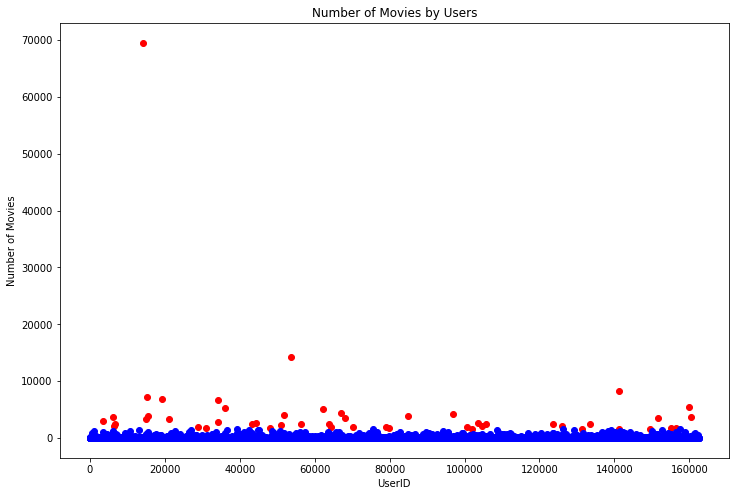

In [194]:

plt.figure(figsize=(12, 8))
plt.scatter(mv_imd_out.userId.unique(), mv_imd_out.groupby(by = 'userId')['movieId'].count(),marker ="o", c ="red")
plt.scatter(mv_imd_no.userId.unique(), mv_imd_no.groupby(by = 'userId')['movieId'].count(), marker ="o", c ="blue")
plt.xlabel('UserID')
plt.ylabel('Number of Movies')
plt.title('Number of Movies by Users')

plt.show()

The scatter plot is showing that a particular user rated close to 70,000 movies. This doesnt look real; we consider an outlier and hence will remove the noise from the analysis.

In [195]:
mv_imd_tag.head(2)

,movieId,title_cast,director,runtime,plot_keywords,title,genres,userId,tag,timestamp
0,1,Tom_Hanks Tim_Allen Don_Rickles Jim_Varney Wal...,John_Lasseter,81.0,toy rivalry cowboy cgi animation,Toy Story (1995),Adventure Animation Children Comedy Fantasy,791,Owned,1515175493
1,1,Tom_Hanks Tim_Allen Don_Rickles Jim_Varney Wal...,John_Lasseter,81.0,toy rivalry cowboy cgi animation,Toy Story (1995),Adventure Animation Children Comedy Fantasy,1048,imdb top 250,1172144394


**3.3.1 Top 10 Directors with Most movies**

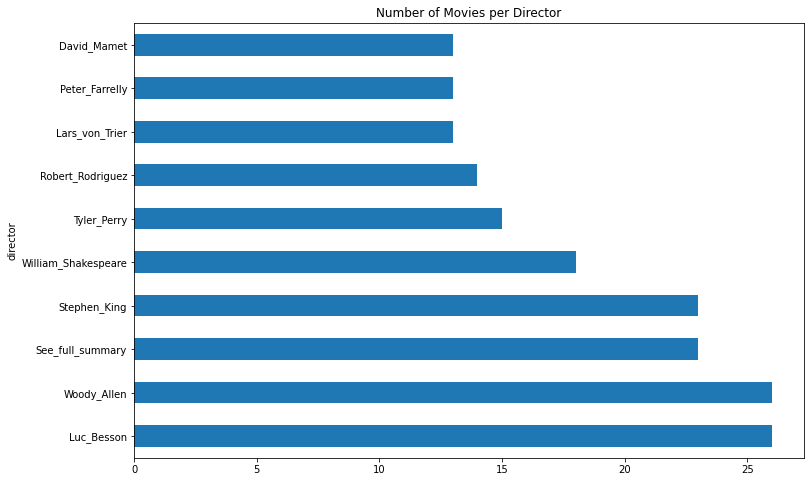

In [196]:
plt.figure(figsize=(12, 8))
(mv_imd.groupby('director')['movieId'].count()
 .sort_values(ascending=False).nlargest(10).plot.barh())
plt.title('Number of Movies per Director')
plt.show()

In [197]:
#list(imdc['director'].unique())

Some labels in the chart above are not actual directors. Example: "william_shakespeare", "see_full_summary". We will remove such labels and associated entries.

In [198]:
import nltk
nltk.download('wordnet')
#

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [199]:
wn = WordNetLemmatizer()

In [200]:
from nltk.corpus import stopwords

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('all')
stopword = set(stopwords.words('english'))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping grammars/basque_grammars.zip.
[nltk_data]    | Downloading package bcp47 to /root/nltk_data.

In [ ]:
def join_words(text):
  text = (' '.join([word for word in text.split(' ') if word not in stopword]))
  text = ' '.join([WordNetLemmatizer().lemmatize(word, pos='v') for word in text.split(' ')])
  return text

In [ ]:
#mv_imd['genres']

In [206]:
item = mv_imd['genres']

text = ' '.join(word for word in item.apply(join_words))
wordclound = WordCloud(stopwords=stopword, background_color = 'black', max_word=50).generate(text)
plt.figure(figsize(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Most Common Genre')
plt.show()

LookupError: ignored